# GWANW 2025 Meeting: LIGO Data Tutorial

This tutorial section covers the basics of LIGO data access and analysis. After finishing this session, you should be able to access publicly-available gravitational wave data, perform some basic manipulations to the data to find the gravitational wave signal. We will also discuss some basic data quality concerns to keep in mind when viewing LIGO data.

If you have any questions, feel free to reach out to me (Ben Mannix bmannix@uoregon.edu)

---


LIGO data can be accessed with the GWpy Python package. This workbook will describe how to download publicly-available gravitational wave data and process it with GWpy. Installation instructions for GWpy may be found [here](https://gwpy.github.io/docs/stable/install/index.html). This tutorial uses version 2.0.3 of GWpy for python 3.6+.

In [3]:
# you may have to install gwpy
!pip install gwpy


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\benma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Now let's import all of the other tools we'll need for this:

In [4]:
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import matplotlib.pyplot as plt
from scipy.signal import get_window
%matplotlib inline

## A Note on time, UTC and GPS:

When talking about the time of an event, given that we have detectors around the globe, it's useful to have a single time standard to compare data. Thus, events are reported in UTC time. However, dates and times are written in way that's easy for humans to read, but not in a way that is easy to do math with. That's where GPS time is useful. GPS time standard counts the number of seconds since 00:00:00 UTC on January 6, 1980. 

Gwpy has the useful function tconvert for converting between GPS times and human-readable times. 

In [5]:
print(tconvert(0))  # What UTC time does the GPS time of 0 correspond to?

1980-01-06 00:00:00


In [6]:
print(tconvert("1980-01-06 00:00:00")) # What GPS time does 1/6/1980 00:00:00 correspond to?

0


In [7]:
print(tconvert('January 6, 1980 00:00:00'))

0


In [8]:
 # What time is it now?
print(tconvert('now'))
print(tconvert(tconvert('now')))

1433776030
2025-06-12 15:06:52


---

## Example event: GW200224_222234

The easiest way to access LIGO data as someone who isn't a collaboration member is through the [Gravitational Wave Open Science Center (GWOSC)](https://www.gw-openscience.org/). For each confidently-detected gravitational-wave event in LIGO & Virgo, GWOSC hosts over an hour of detector data from each observatory (if it was operating).

We will be mostly looking at GW200224 in this session. This was a gravitational wave (GW) candidate seen when all three observatories were operating. It was a merger of a $40.0^{+6.9}_{-4.5}$ solar masss black hole and a $32.5^{+5.0}_{-7.2}$ which produced a $68.6^{+6.6}_{-4.7}$ solar mass black hole. Approximately $7\times10^{47}$ Joules of energy were emitted as gravitational waves in the process. The data can be viewed and downloaded from the event's GWOSC page [here](https://www.gw-openscience.org/eventapi/html/GWTC-3-confident/GW200224_222234/v1).

According to info for this event, the signal should be found on February 24, 2020 at 22:22:34 UTC. 

In [14]:
t0 = tconvert('Feb 24 2020 22:22:34')   
# Let's look in a reasonable window of time around the event
t_start = t0 - 32
t_end = t0 + 32
h1_data = TimeSeries.fetch_open_data(ifo = 'H1', start = t_start, end = t_end, sample_rate = 16384) 

# note: fetch_open_data queries the LIGO public events. For LIGO members, see TimeSeries.get for more general use

Let's take a look at the resulting timeseries by plotting it:

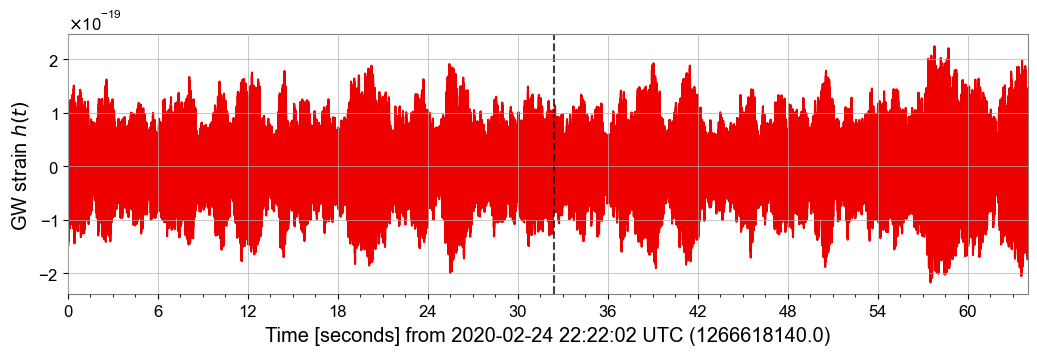

In [16]:
plot = h1_data.plot(c = 'gwpy:ligo-hanford')
plt.ylabel(r'GW strain $h(t)$')
plt.axvline(1266618172.4, ls = '--', alpha = .75, c= 'k')
plot.show()

The black dashed line indicates where we're supposed to see the gravitational wave event. 

Now, let's take a look at the information contained within a TimeSeries object:

Each gwpy.timeseries.TimeSeries object has several attributes in addition to the array of $h(t)$ measurements.

The most useful thing is the value of $h(t)$ at each point in time:

In [17]:
print(h1_data.value)  # The list of h(t) at each time

[ 3.04651488e-20 -1.46678592e-21  1.54148711e-20 ...
 -1.12415586e-19 -1.20887348e-19 -1.22343519e-19]


We can check that the size of our data makes sense by considering the sampling rate and length of time we pulled. According to our sampling rate, there should 16384 data points per second:

In [18]:
print(len(h1_data))
print(64*16384)

1048576
1048576


Let's take a look at all the information this TimeSeries object contains:

In [19]:
print(h1_data) #another way to view the same information

TimeSeries([ 3.04651488e-20, -1.46678592e-21,  1.54148711e-20,
            ..., -1.12415586e-19, -1.20887348e-19,
            -1.22343519e-19]
           unit: dimensionless,
           t0: 1266618140.0 s,
           dt: 6.103515625e-05 s,
           name: Strain,
           channel: None)


We can also call specific pieces of information individually:

In [20]:
print(h1_data.unit)         # Strain is unitless (meters/meters), so this is just a blank line
print(h1_data.t0)           # GPS start time of the data
print(h1_data.dt)           # Time increments between data points
print(h1_data.sample_rate)  # Sample rate of channel
print(h1_data.times)        # List of GPS times at which the  data is sampled
print(h1_data.name)         # Descriptive name for the dataset


1266618140.0 s
6.103515625e-05 s
16384.0 Hz
[1.26661814e+09 1.26661814e+09 1.26661814e+09 ... 1.26661820e+09
 1.26661820e+09 1.26661820e+09] s
Strain


Calling the object will also return the value of $h(t)$:

In [21]:
h1_data

<TimeSeries([ 3.04651488e-20, -1.46678592e-21,  1.54148711e-20,
             ..., -1.12415586e-19, -1.20887348e-19,
             -1.22343519e-19]
            unit=Unit(dimensionless),
            t0=<Quantity 1.26661814e+09 s>,
            dt=<Quantity 6.10351562e-05 s>,
            name='Strain',
            channel=None)>

Let's now take a close look at the data to see if we can find GW200224 by bringing Livingston in too:

In [22]:
l1_data = TimeSeries.fetch_open_data(ifo = 'L1', start = t_start, end = t_end, sample_rate = 16384, verbose = False) #note the change in ifo

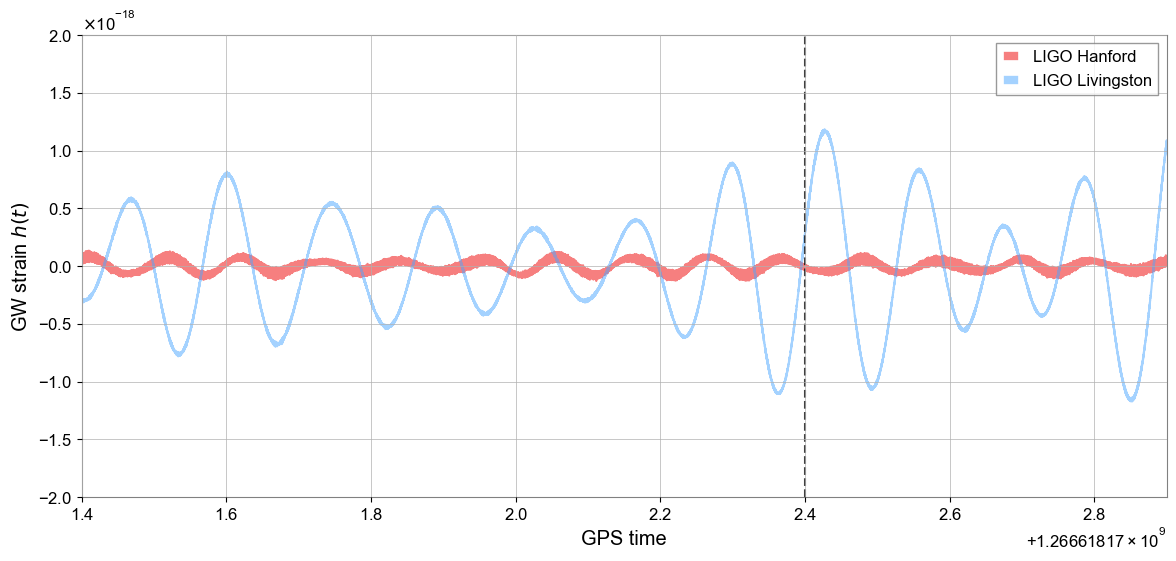

In [23]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlabel('GPS time')
ax.set_xlim(1266618172.4- 1, 1266618172.4 + 0.5)  # Event time from the listing on GraceDB
ax.set_ylim(-2 * 10**(-18), 2 * 10**(-18))
ax.legend()
plt.axvline(1266618172.4, ls = '--', alpha = .75, c= 'k')
plot.show()

There doesn't appear to be anything exceptional happening in the detectors at the quoted merger time. What gives?

---

## Cleaning the data

To actually see the gravitational wave signal, we need to do some work removing noise from our data. We'll use tools from Fourier analysis and signal processing to accomplishi this. 

It is easy to compute the frequency-domain representation of the $h(t)$ data for either detector. We can perform a Fast Fourier Transform (FFT) to take the information from time space to frequency space.

In [24]:
h1_data_freq_domain = h1_data.fft()

This produces a FrequencySeries object which has similar properties and attributes to a TimeSeries.

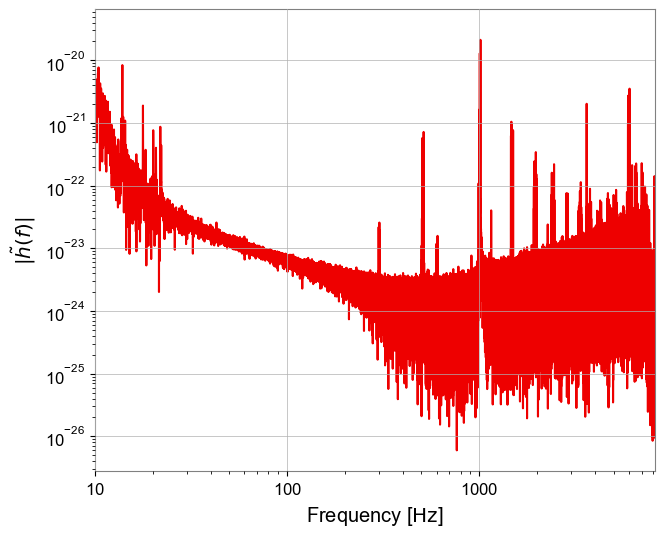

In [25]:
plot = h1_data_freq_domain.abs().plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log', figsize= (8,6))
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlim(10, 8192)
plot.show();

This gives us a sense of what level of noise we expect at each frequency. However, it looks quite erratic and messy. Due to the fact that we're taking a Fourier transform of a finite signal, we can get artifacts called "spectral leakage" due to the data getting cut off at the start and end of our time segment. We can reduce these effects by "windowing" our data:

In [26]:
window_fct = get_window(window = 'hann', Nx = h1_data.size)

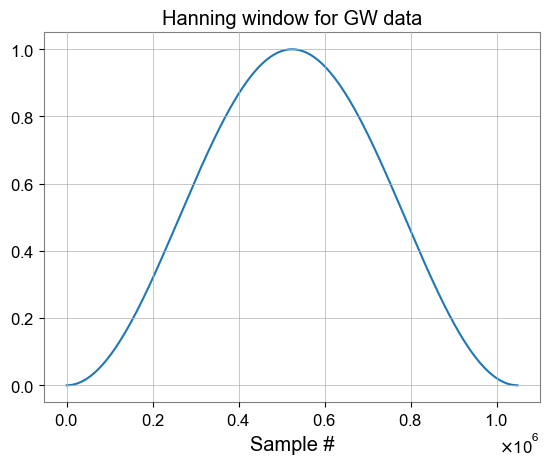

In [27]:
plt.plot(window_fct)
plt.xlabel('Sample #')
plt.title('Hanning window for GW data')
plt.show()

In [28]:
windowed_h1_data = window_fct * h1_data

The result of the windowing is to decrease the values of $h(t)$ recorded at the start and end of the dataset.

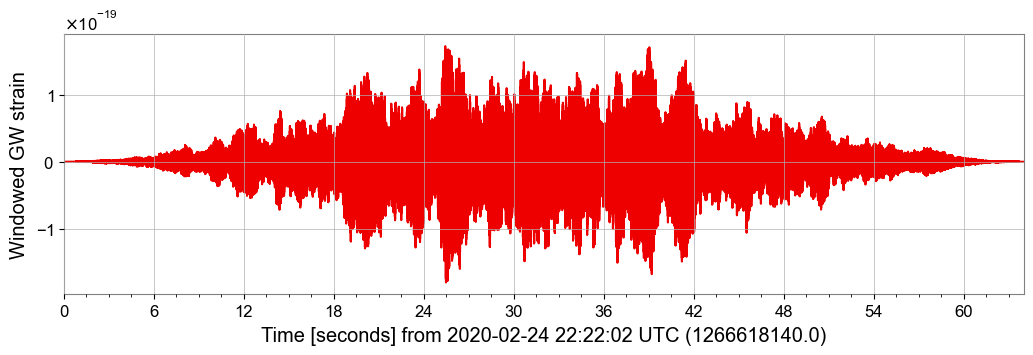

In [29]:
plot = windowed_h1_data.plot(c = 'gwpy:ligo-hanford')
plt.ylabel(r'Windowed GW strain')
plot.show()

Revisting the FFT to see what effect the window had:

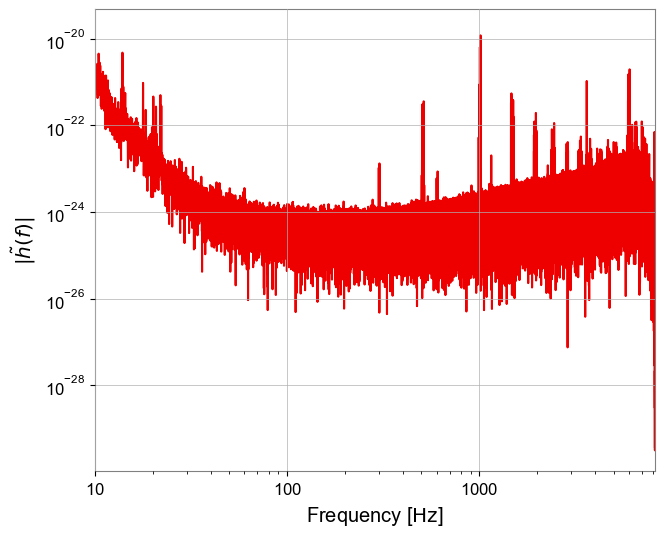

In [30]:
h1_windowed_data_freq_domain = windowed_h1_data.fft()
plot = h1_windowed_data_freq_domain.abs().plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log', figsize = (8,6))
plt.ylabel(r'$|\tilde{h}(f)|$')
plt.xlim(10, 8192)
plot.show()

It's looking cleaner now, but we can still do better.

By combining several FFTs, we are able to get a snapshot of the detector's sensitivity at the time of the event that isn't subject to short variations in detector noise. The windowing step is done automatically by the asd() method.

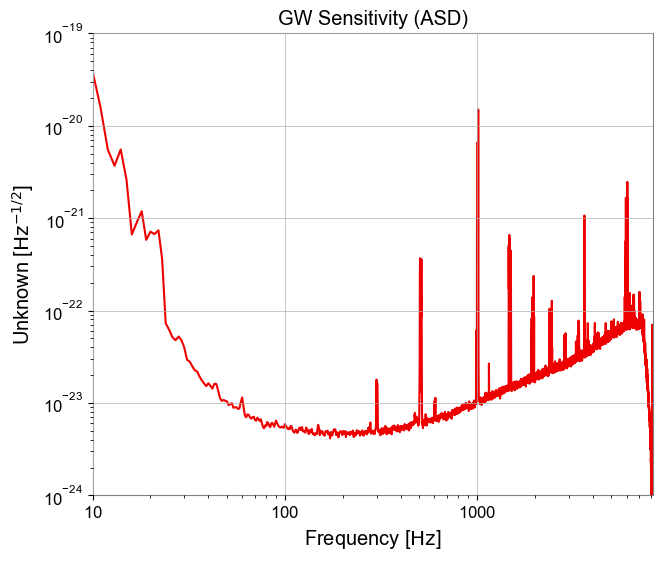

In [31]:
h1_asd = h1_data.asd(fftlength = 1, overlap = 0.5, window = 'hann', method = 'welch')
plot = h1_asd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log',  figsize = (8,6))
plt.title('GW Sensitivity (ASD)')
plt.xlim(10, 8192)
plt.ylim(10e-25,1e-19)
plt.show()

This is starting to look like the image of a sensitivity curve we're familiar with seeing. Our Amplitdue Spectral Density (ASD) plot which tells us the level of noise we expect in each part of frequency. The lower the curve, the lower the level of noise at that frequency and thus the more sensitive we are to gravitational waves. 

We can compute the PSD just as we found the ASD. Note the different units.

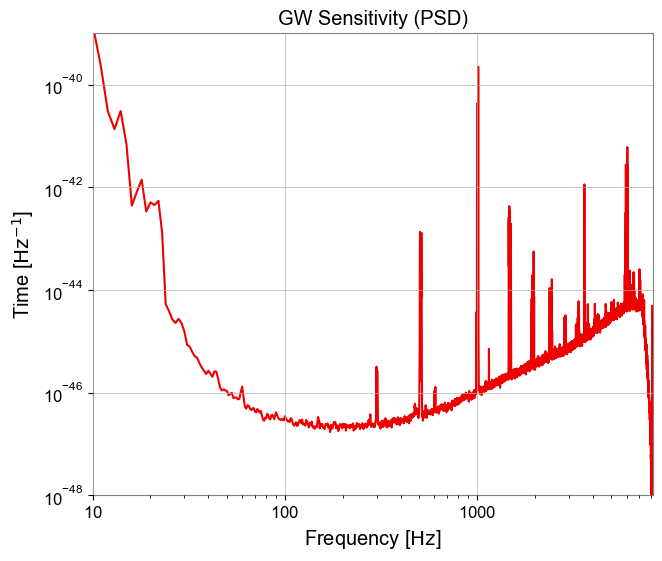

In [32]:
h1_psd = h1_data.psd(fftlength = 1, overlap = 0.5, window = 'hann', method = 'welch')
plot = h1_psd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log', figsize = (8,6))
plt.title('GW Sensitivity (PSD)')
plt.xlim(10, 8192)
plt.ylim(1e-48,1e-39)
plt.show()

Another technique we can implement is whitening the data. GWpy uses inverse spectrum truncation to boost the amplitude of the signal at low-amplitude frequencies and reduce the signal amplitude at high amplitude frequencies. ASDs like the ones we have made are used to whiten the data.

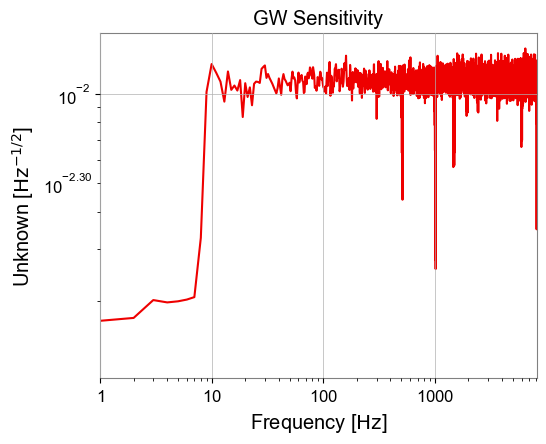

In [33]:
h1_data_whitened = h1_data.whiten()
h1_whitened_asd = h1_data_whitened.asd(fftlength = 1, overlap = 0.5, window = 'hann', method = 'welch')
plot = h1_whitened_asd.plot(c = 'gwpy:ligo-hanford', xscale = 'log', yscale = 'log')
plt.title('GW Sensitivity')
plt.show()

The signal is approixmately "white" or "flat" above 10 Hz. We're really not interested in the low frequency content anyway, so this should be good. We will highpass the signal above 20 Hz to be sure. Now we can repeat the process for LIGO Livingston.

In [34]:
h1_final_data = h1_data.highpass(20).whiten()

In [35]:
l1_final_data = l1_data.highpass(20).whiten()

Now let's take a close look where we expect the gravitational wave signal to be:

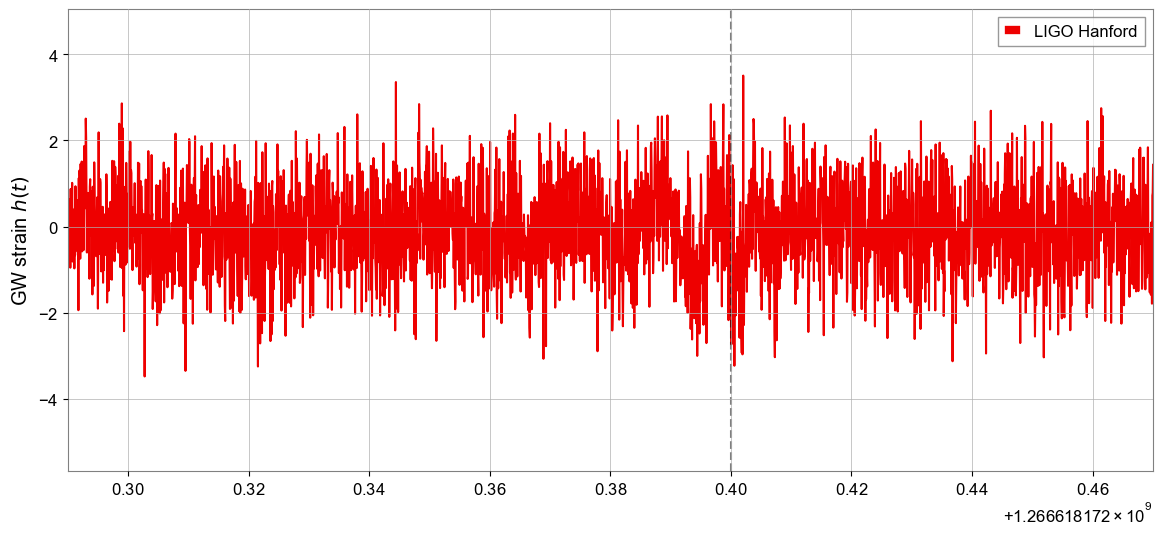

In [43]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1266618172.4 - .11, 1266618172.4+ .07)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1266618172.4, ls = '--', alpha = .5, c= 'k')
plot.show()

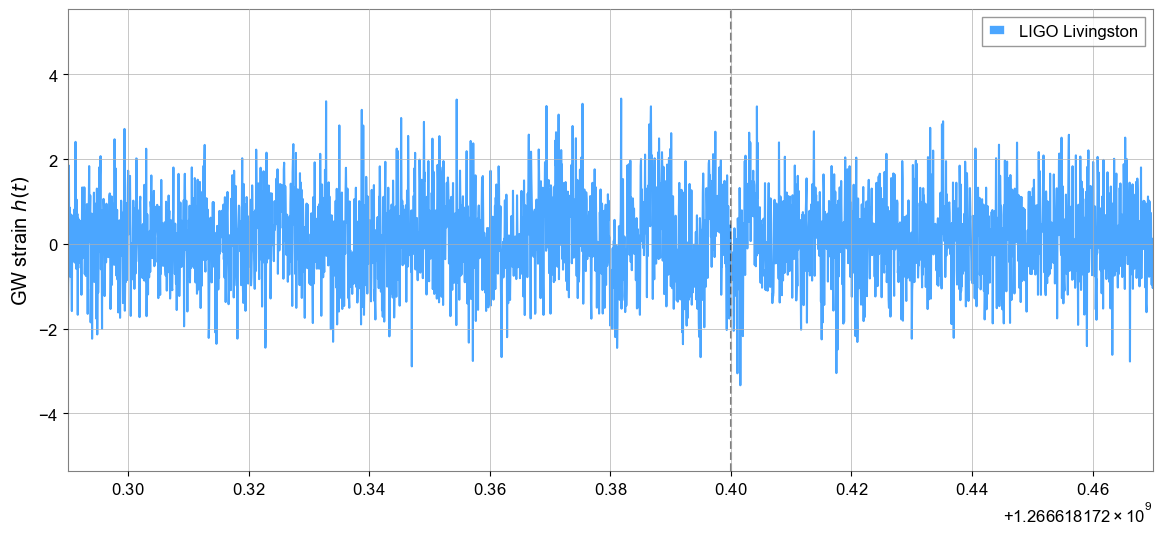

In [44]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston')
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1266618172.4 - .11, 1266618172.4 + .07)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1266618172.4, ls = '--', alpha = .5, c= 'k')
plot.show()

Zooming in, the GW can be picked out of both detector's data by eye.

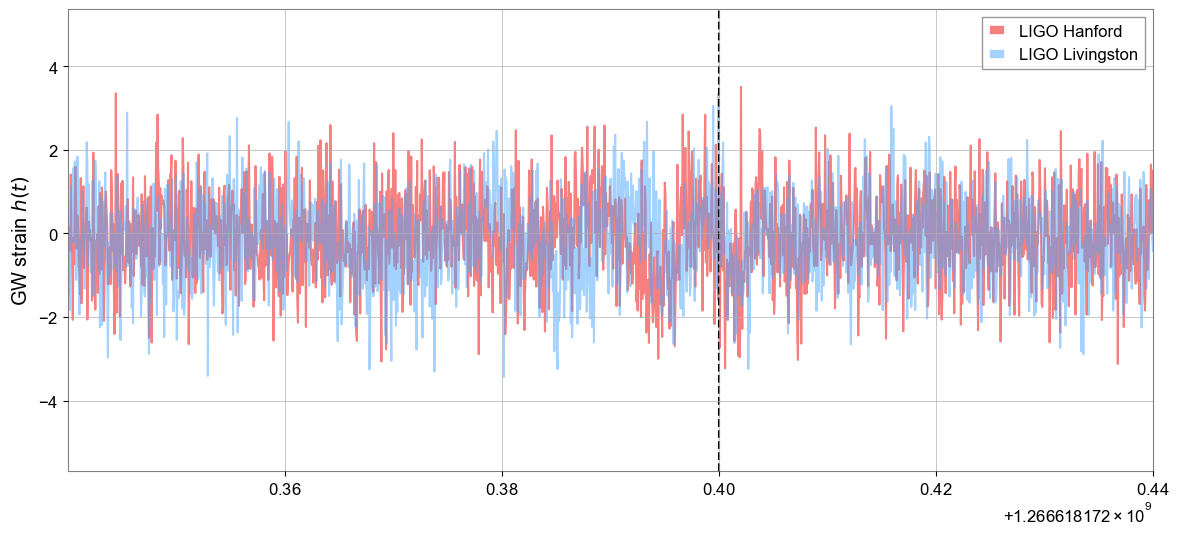

In [38]:
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1266618172.4 - .06,1266618172.4 + .04)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1266618172.4, ls = '--', alpha = 1, c= 'k')
plot.show()

However, the signals don't seem to overlap. There are two steps we'll do to fix this:

1. Flip the Livingston time series by multiplying it by -1 (this is an effect due to the relative orientation of the detectors)
2. Shift Livingston's data by 1.6 ms due to the fact that gravitational waves travel at a finite speed (c)

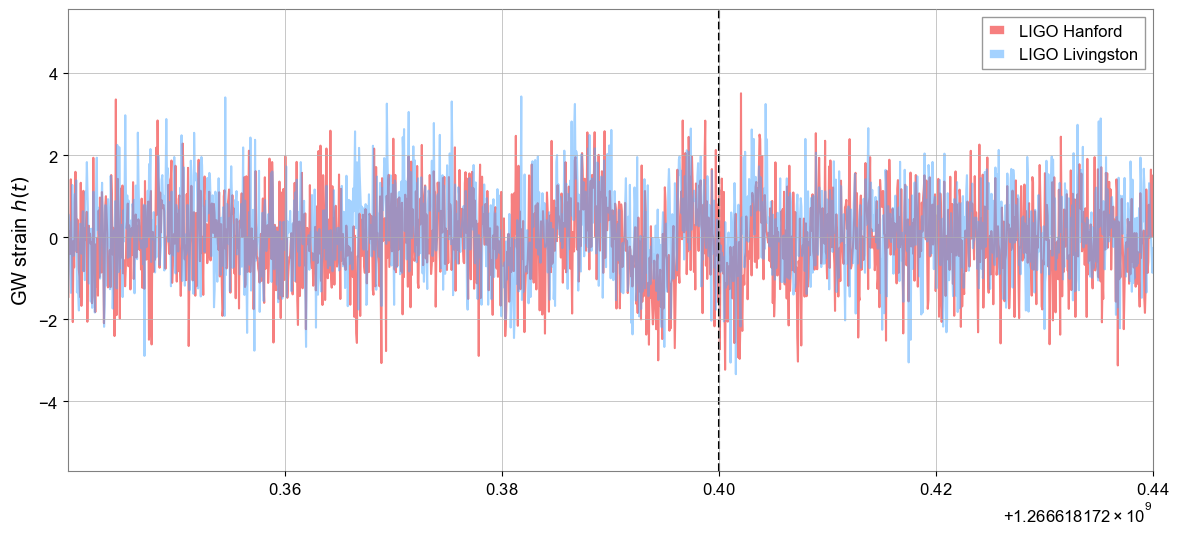

In [39]:
l1_final_data *= -1
l1_final_data.shift('1.6ms')
plot = Plot(figsize = (14, 6))
ax = plot.gca()
ax.plot(h1_final_data, label = 'LIGO Hanford', c = 'gwpy:ligo-hanford', alpha = .5)
ax.plot(l1_final_data, label = 'LIGO Livingston', c = 'gwpy:ligo-livingston', alpha = .5)
ax.set_ylabel(r'GW strain $h(t)$')
ax.set_xlim(1266618172.4 - .06,1266618172.4 + .04)  # Event time from the listing on GraceDB
ax.legend()
plt.axvline(1266618172.4, ls = '--', alpha = 1, c= 'k')
plot.show()

And voilà! That is a gravitational wave signal that is present in both detectors. 

Spectrograms are also a useful to show information. They show the information in frequency space as it evolves with time.

In [40]:
specgram = h1_final_data.spectrogram2(fftlength=1/32, overlap=1/64) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass

C:\Users\benma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gwpy\plot\plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


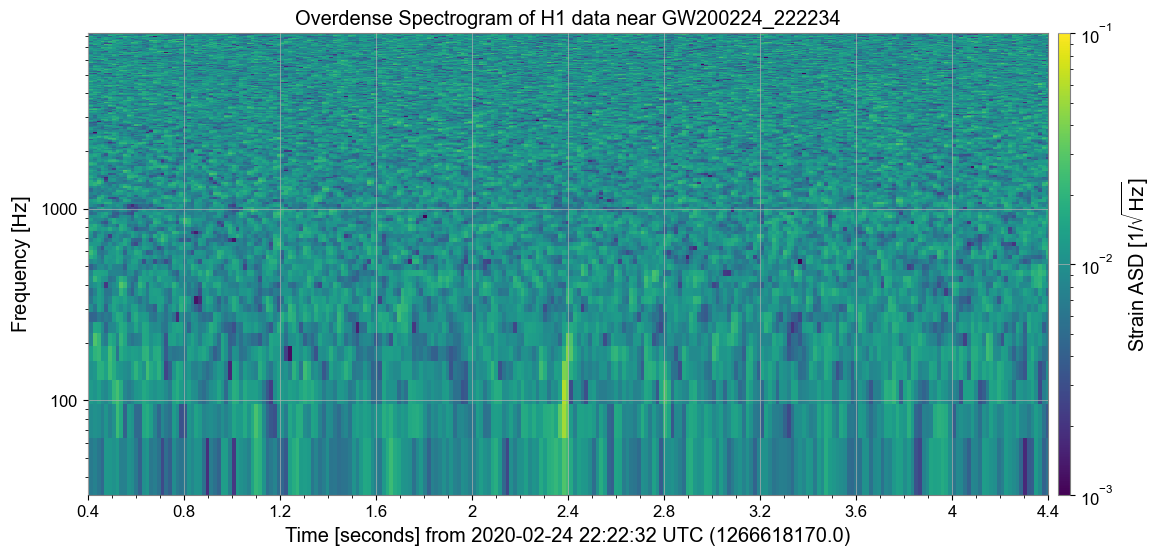

In [41]:
plot = specgram.plot(norm='log', cmap='viridis', yscale='log', vmin = 1e-3, vmax = .1)
ax = plot.gca()
ax.set_title('Overdense Spectrogram of H1 data near GW200224_222234')
ax.set_xlim(1266618170.4, 1266618174.4)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

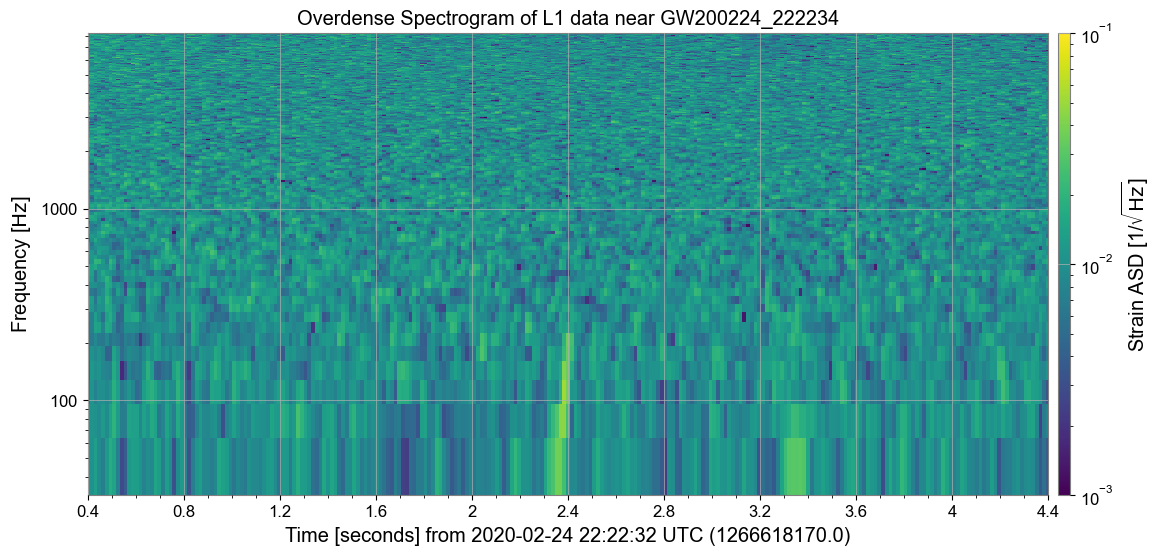

In [42]:
specgram = l1_final_data.spectrogram2(fftlength=1/32., overlap=1/64.) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass
plot = specgram.plot(norm='log', cmap='viridis', yscale='log', vmin = 1e-3, vmax = .1)
ax = plot.gca()
ax.set_title('Overdense Spectrogram of L1 data near GW200224_222234')
ax.set_xlim(1266618170.4, 1266618174.4)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

It's important to note that there's more of the signal present than what our eyes can see in the spectrogram. This particular signal chosen has a Signal-to-Noise Ratio (SNR) of about 19, making it decently loud. Our search algorithms are sosphisticated enough to detect lower SNR signals where sometimes the signal isn't even visible at all. (See spectrograms for [GW210115](https://iopscience.iop.org/article/10.3847/2041-8213/ac082e) )

## Glitches

Glitches are short-duration transients with various causes and shapes in the data. An infamous glitch is the the one that occurred during the inspiral of GW170817, the first binary neutron star merger LIGO observed. Here is an image of the glitch taken from [this paper.](https://ui.adsabs.harvard.edu/abs/2018PhRvD..98h4016P/abstract)

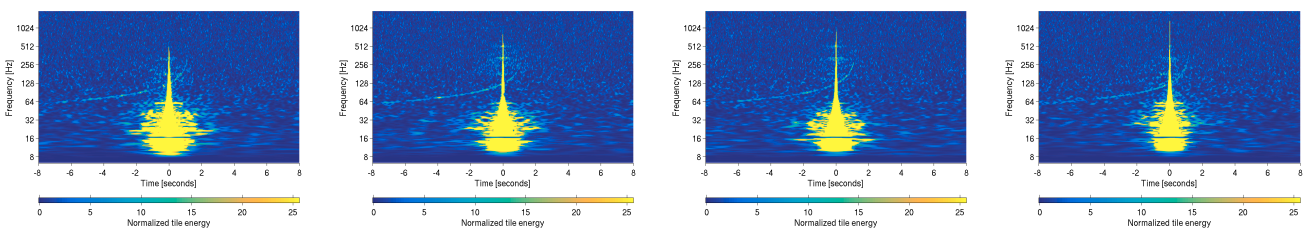